# Welcome to your anomaly detection tool for the BCM1F detector at CMS! If running this on jupyter notebook, make sure to run this first cell to ensure adtk is mounted in the correct path. Otherwise skip to cell 2 to run the function to load in the hd5 file as well as mount all necessary packages.

In [1]:
import site
import sys

user_site = site.USER_SITE
if user_site not in sys.path:
    sys.path.append(user_site)
    print(f"Added {user_site} to Python path.")
print("Updated Python path:", sys.path)

try:
    from adtk.data import validate_series
    print("adtk module imported successfully.")
except ModuleNotFoundError:
    print("ModuleNotFoundError: No module named 'adtk'")

Added /eos/user/k/kream/.local/lib/python3.9/site-packages to Python path.
Updated Python path: ['/eos/home-i01/k/kream/SWAN_projects/bril', '/cvmfs/sft.cern.ch/lcg/releases/condor/23.0.2-36b2d/x86_64-el9-gcc13-opt/lib/python3', '/cvmfs/sft.cern.ch/lcg/views/LCG_105a_swan/x86_64-el9-gcc13-opt/lib/python3.9/site-packages/itk', '/cvmfs/sft.cern.ch/lcg/views/LCG_105a_swan/x86_64-el9-gcc13-opt/python', '/cvmfs/sft.cern.ch/lcg/views/LCG_105a_swan/x86_64-el9-gcc13-opt/lib', '', '/cvmfs/sft.cern.ch/lcg/views/LCG_105a_swan/x86_64-el9-gcc13-opt/lib/python3.9/site-packages', '/usr/local/lib/swan/nb_term_lib', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.12-9a1bc/x86_64-el9-gcc13-opt/lib/python39.zip', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.12-9a1bc/x86_64-el9-gcc13-opt/lib/python3.9', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.12-9a1bc/x86_64-el9-gcc13-opt/lib/python3.9/lib-dynload', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.12-9a1bc/x86_64-el9-gcc13-opt/lib/python3.9/site-packages', '/cv

## Load in packages.

In [2]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tables
from adtk.data import validate_series
from adtk.detector import ThresholdAD, LevelShiftAD
from datetime import datetime
import math
import warnings
import os
import scipy.optimize as opt  
from IPython.display import display_html
from IPython.core.display import display, HTML
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

In [3]:
happy_message = ["Gee whiskers!", "As Post Malone said - Congratulations!", "Hats off to you!", "Perfect time for a coffee break!", "Cheers, mate!", "Here's a gold star for you!", "You're doing great sweetie!", "Slay queen!",
                "Pat yourself on the back!", "We did it, we did it, we did it yay!", "Look at you go!", "Wave your hands in the air like you just don't care!", "It's a party in the USA!", "Aye yay captain!", "Skippidy doo dah day!",
                "You go girl!", "You just bopped to the top!", "Skip to my loo my darling!", "Yahtzee!", "Victory lap!", "You just passed go - collect $200!"]

## Run the code below to load in the data table and create respective dataframes.
## For the adtk named dataframes, we define them to hold only the date-time and luminosity values to apply the anomaly detection algorithm. Make sure before running the algorithm the data is in this format, where the date-time is also the index of the dataframe. 

In [14]:
import pathlib
#list(pathlib.Path('/eos/cms/store/group/dpg_bril/comm_bril/2023/physics/').glob('*.pkl'))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6672 entries, 0 to 6671
Data columns (total 52 columns):
 #   Column                        Non-Null Count  Dtype              
---  ------                        --------------  -----              
 0   fillnum                       6672 non-null   int64              
 1   runnum                        6672 non-null   int64              
 2   lsnum                         6672 non-null   int64              
 3   nbnum                         6672 non-null   int64              
 4   hfetlumi_avgraw               6672 non-null   float32            
 5   hfetlumi_avg                  6672 non-null   float32            
 6   hfetlumi_bxraw                6672 non-null   float32            
 7   hfetlumi_bx                   6672 non-null   float32            
 8   remuslumi_avgraw              6672 non-null   float32            
 9   remuslumi_avg                 6672 non-null   float32            
 10  beam_intensity1               6668 n

In [15]:
fill_number = 9066
hd5 = pd.read_pickle(f'/eos/cms/store/group/dpg_bril/comm_bril/2023/physics/{fill_number}.pkl')
hd5_cleaned = hd5.dropna(how = 'all')
rename_dict = {f'bcm1fagghist_data_{i:02}': f'bcm1faggs_{i}' for i in range(1, 49)}
bcm1f_columns = [f'bcm1faggs_{i}' for i in range(1, 49)]
hd5_cleaned = hd5_cleaned.rename(columns=rename_dict)
hd5_cleaned = hd5_cleaned.loc[hd5_cleaned['beam_status'] == "STABLE BEAMS"]
hd5_cleaned = hd5_cleaned[(hd5_cleaned[bcm1f_columns] >= 0).all(axis=1)]

channels = range(1,49)
ch_data = [hd5_cleaned[['fillnum', 'runnum', 'lsnum', 'nbnum','date_time', f'bcm1faggs_{ch}']].rename(columns={f'bcm1faggs_{ch}': 'lumi'}) for ch in channels]

def ch_ratio(hd5: pd.DataFrame, ch: int, ref_thr: float = 0.1) -> pd.DataFrame:
    if f'bcm1faggs_{ch}' not in hd5.columns:
        print(f"Column 'bcm1faggs_{ch}' does not exist.")
        return pd.DataFrame()  
    
    ch_data = hd5[hd5[f'bcm1faggs_{ch}'] > 0].copy() 
    other_channels = [f'bcm1faggs_{other_ch}' for other_ch in range(1, 49) if other_ch != ch]
    
    ch_data['lumi_ref'] = hd5[other_channels].median(axis=1)
    ch_data = ch_data[ch_data['lumi_ref'] >= ref_thr * ch_data['lumi_ref'].mean()].reset_index(drop=True)
    ch_data['ratio'] = ch_data[f'bcm1faggs_{ch}'] / ch_data['lumi_ref']
    return ch_data

ch_ratios = [ch_ratio(hd5=hd5_cleaned, ch=ch, ref_thr=0.1) for ch in channels]
assert len(ch_data) == len(channels), "Mismatch in length of ch_data and channels"
lumi_data = [ch_data[ch-1]['lumi'] for ch in channels]  # ch-1 for zero-based indexing
dt_data = [ch_data[ch-1]['date_time'] for ch in channels]

df_data = pd.Series(ch_data)
df_ratio = pd.Series(ch_ratios).dropna(how = 'all')
df_ratio.index = df_ratio.index + 1
df_ratio_adtk = pd.Series([ch_ratios[ch-1]['ratio'] for ch in channels])

lumi_df = pd.DataFrame(lumi_data).T
lumi_column_names = [f'lumi{i}' for i in channels]
lumi_df.columns = lumi_column_names

dt_df = pd.DataFrame(dt_data).T
dt_column_names = [f'date-time{i}' for i in channels]
dt_df.columns = dt_column_names

adtk_df = pd.concat([pd.DataFrame({f'lumi_{i}': lumi_data[i-1], f'date-time_{i}': dt_data[i-1]})
                     for i in channels], axis=1)

titles = [f'ch{ch} lumi' for ch in channels]
titles_r = [f'ch{ch}/all' for ch in channels]

hd5_cleaned

,fillnum,runnum,lsnum,nbnum,pltlumizero_avgraw,pltlumizero_avg,pltlumizero_bxraw,pltlumizero_bx,bcm1flumi_avgraw,bcm1flumi_avg,...,bcm1futcalumi_maskhigh,bcm1futcalumi_bxraw,bcm1futcalumi_bx,beam_intensity2,beam_egev,beam_intensity1,beam_status,beam_ncollidable_bxintensity,date_time,beam_ncollidable
8,9066.0,370664.0,24.0,52.0,0.000004,0.000175,0.000004,0.000175,0.031872,2.692324,...,2.147484e+09,0.016584,1.422848,3.931782e+14,6799.439941,3.889568e+14,STABLE BEAMS,2452.0,2023-07-14 07:40:16.214812416+00:00,NaN
9,9066.0,370664.0,24.0,56.0,0.000012,0.000412,0.000012,0.000412,0.031665,2.674872,...,2.147484e+09,0.017243,1.468510,3.931717e+14,6799.319824,3.889430e+14,STABLE BEAMS,2452.0,2023-07-14 07:40:17.678706176+00:00,NaN
10,9066.0,370664.0,24.0,60.0,0.000031,0.001179,0.000031,0.001179,0.031813,2.687386,...,2.147484e+09,0.017216,1.471174,3.931580e+14,6799.319824,3.889206e+14,STABLE BEAMS,2452.0,2023-07-14 07:40:19.142012416+00:00,NaN
11,9066.0,370664.0,24.0,64.0,0.000012,0.000469,0.000012,0.000469,0.031842,2.689841,...,2.147484e+09,0.018164,1.550858,3.931532e+14,6799.319824,3.889103e+14,STABLE BEAMS,2452.0,2023-07-14 07:40:20.594193920+00:00,NaN
12,9066.0,370664.0,25.0,4.0,0.000018,0.000627,0.000018,0.000627,0.031584,2.667989,...,2.147484e+09,0.018547,1.582826,3.931390e+14,6799.319824,3.888879e+14,STABLE BEAMS,2452.0,2023-07-14 07:40:22.053700096+00:00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3087,9066.0,370667.0,115.0,4.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,0.021424,1.650083,3.489244e+09,6799.319824,5.099183e+09,STABLE BEAMS,0.0,2023-07-14 08:54:55.212593664+00:00,0.0
3088,9066.0,370667.0,115.0,8.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,0.020112,1.554216,2.638994e+09,6799.319824,5.549897e+09,STABLE BEAMS,0.0,2023-07-14 08:54:56.676493824+00:00,0.0
3089,9066.0,370667.0,115.0,12.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,0.021241,1.634547,3.239251e+09,6799.319824,6.066369e+09,STABLE BEAMS,0.0,2023-07-14 08:54:58.125893632+00:00,0.0
3090,9066.0,370667.0,115.0,16.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,0.020295,1.565295,3.316172e+09,6799.439941,8.810383e+09,STABLE BEAMS,0.0,2023-07-14 08:54:59.581587712+00:00,0.0


In [59]:
channels_failed = [24]
channels_good = [ch for ch in channels if ch not in channels_failed]

all_lumi_values = []
for ch in channels_good:
    all_lumi_values.extend(df_data[ch-1]['lumi'].values)  

median_channel_series = pd.Series(all_lumi_values).median()
channel_median_diff = {}

for ch in channels_good:
    difference_plt_median = np.abs(df_data[ch-1]['lumi'] - median_channel_series) 
    median_diff = difference_plt_median.median()
    channel_median_diff[ch] = median_diff 

closest_channel = min(channel_median_diff, key=channel_median_diff.get)

print(f"The reference channel for fill {fill_number} is Channel {closest_channel}.")
reference = [closest_channel]

The reference channel for fill 9066 is Channel 37.


#### Now plot all individual channels and all ratio channels with their respective histograms to see what the fill looks like. One thing we care about is the distribution of the ratio channel histogram for our channel selection: if the histogram shape is bad, keep it as a possibility to eliminate said channel.

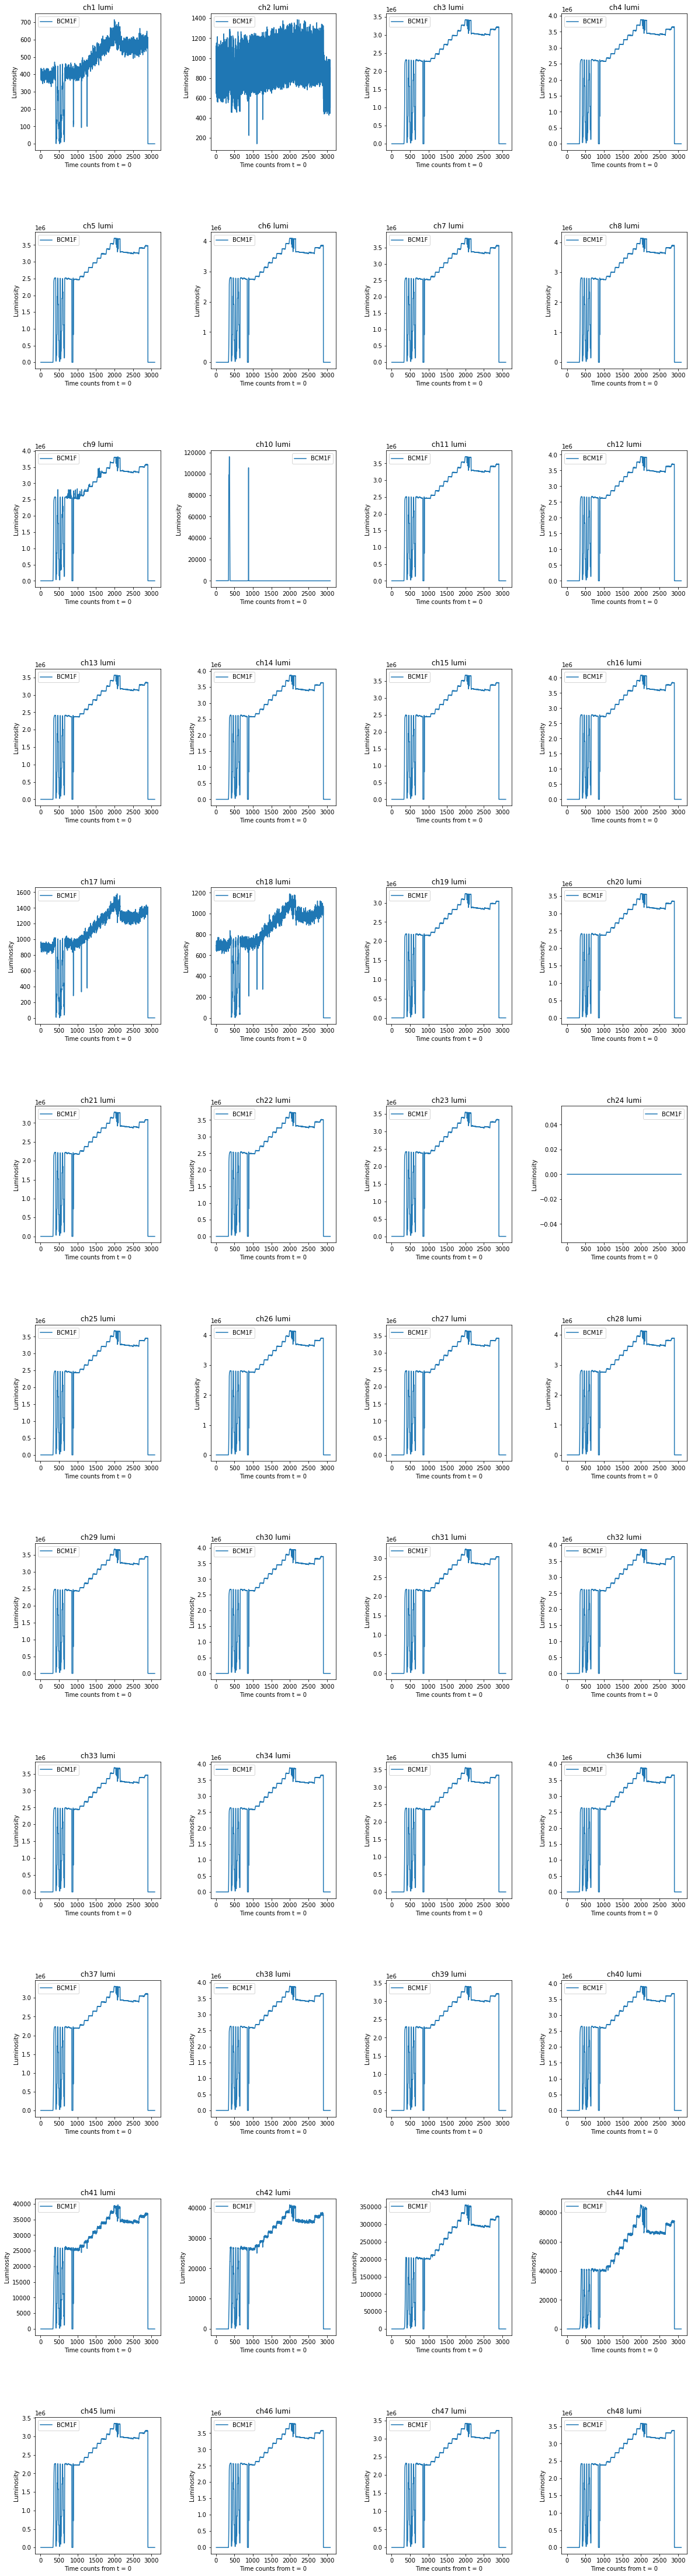

In [7]:
fig, axes = plt.subplots(12, 4, figsize=(20, 80))

for i, ax in enumerate(axes.flatten()):
    df_data[i].lumi.plot(ax=ax, title=titles[i], label='BCM1F')
    ax.set_xlabel("Time counts from t = 0")
    ax.set_ylabel("Luminosity")
    ax.legend(loc='best')


plt.subplots_adjust(wspace=0.4, hspace=0.6)
plt.show()

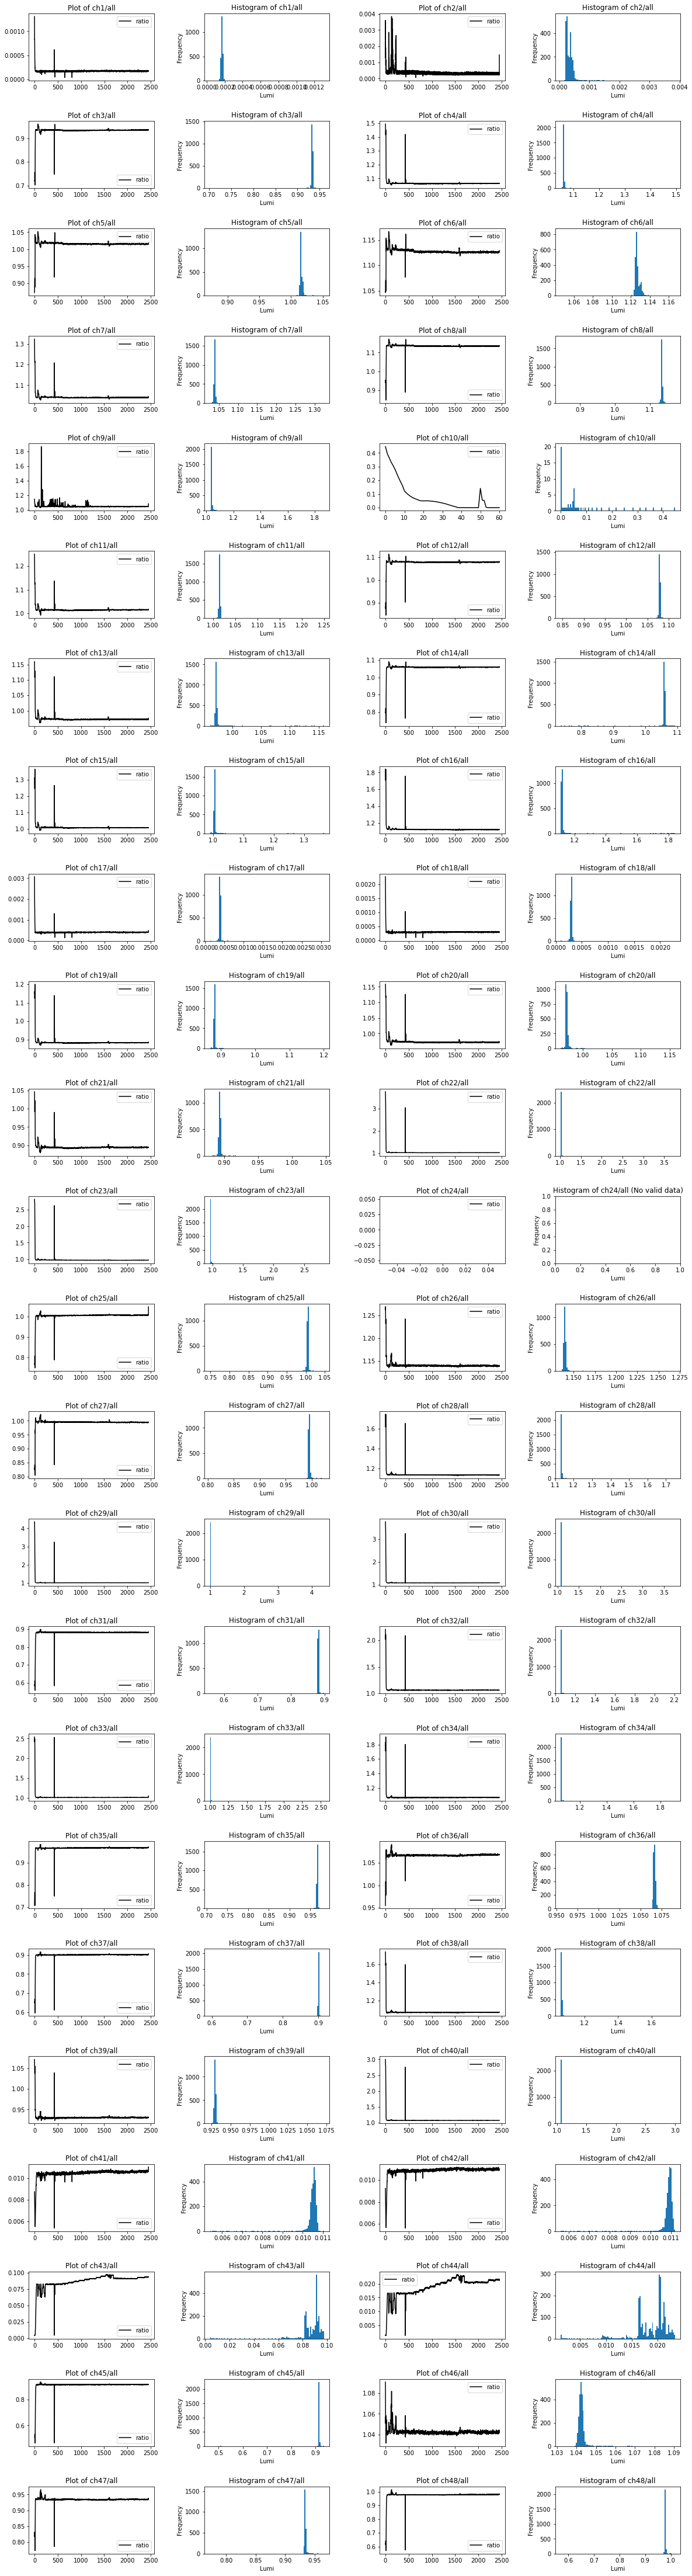

In [8]:
fig, axes = plt.subplots(24, 4, figsize=(20, 80))

for i, ax in enumerate(axes.flatten()):
    channel_index = (i // 2) + 1  # Adjust index for df_ratio (starts from 1)
    title_index = i // 2  # Corresponding index for titles_r (starts from 0)

    if channel_index in df_ratio:
        if i % 2 == 0:
            df_ratio[channel_index].plot(y='ratio', color='black', ax=ax)
            if title_index < len(titles_r):
                ax.set_title(f"Plot of {titles_r[title_index]}")
            else:
                ax.set_title(f"Plot of Channel {channel_index}")
        else:
            valid_data = df_ratio[channel_index]['ratio'].replace([np.inf, -np.inf], np.nan).dropna()
            
            if not valid_data.empty:
                ax.hist(valid_data, bins=100, range=(valid_data.min(), valid_data.max()))
                if title_index < len(titles_r):
                    ax.set_title(f"Histogram of {titles_r[title_index]}")
                else:
                    ax.set_title(f"Histogram of Channel {channel_index}")
                ax.set_xlabel("Lumi")
                ax.set_ylabel("Frequency")
            else:
                if title_index < len(titles_r):
                    ax.set_title(f"Histogram of {titles_r[title_index]} (No valid data)")
                else:
                    ax.set_title(f"Histogram of Channel {channel_index} (No valid data)")
                ax.set_xlabel("Lumi")
                ax.set_ylabel("Frequency")
    else:
        ax.set_title(f"Data for Channel {channel_index} not found.")
        ax.set_xlabel("Lumi")
        ax.set_ylabel("Frequency")

plt.subplots_adjust(wspace=0.4, hspace=0.6)
plt.show()

# Begin Defining Functions used for Channel Selection

In [9]:
def round_small_vals(x):
    if np.abs(x) < 0.1:
        return 0

def clean_data(df):
    if isinstance(df, pd.DataFrame):
        first_vals = df.iloc[:300].applymap(round_small_vals)
        first_vals = first_vals.replace(0, np.nan)
        cleaned_df = df.copy()
        cleaned_df.iloc[:300] = first_vals 
    elif isinstance(df, pd.Series):
        first_vals = df.iloc[:300].apply(round_small_vals)
        first_vals = first_vals.replace(0, np.nan)
        cleaned_df = df.copy()
        cleaned_df.iloc[:300] = first_vals
    cleaned_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    cleaned_df.dropna(inplace=True)
    return cleaned_df


def detect_anomalies(df, threshold_high, threshold_low, levelshift_c_value, levelshift_window):
    df = clean_data(df)
    df = validate_series(df)
    threshold_ad = ThresholdAD(high=threshold_high, low=threshold_low)
    threshold_anomalies = threshold_ad.detect(df)
    threshold_true_anomalies = threshold_anomalies[threshold_anomalies == True]
    threshold_anomaly_dates = threshold_true_anomalies.index

    level_shift_ad = LevelShiftAD(c=levelshift_c_value, window=levelshift_window)
    levelshift_anomalies = level_shift_ad.fit_detect(df)
    levelshift_true_anomalies = levelshift_anomalies[levelshift_anomalies == True]
    levelshift_anomaly_dates = levelshift_true_anomalies.index
    levelshift_anomalies_all = set(levelshift_anomaly_dates)
    
    combined_anomalies = set(threshold_anomaly_dates).union(levelshift_anomalies_all)
    return combined_anomalies, threshold_anomaly_dates, levelshift_anomalies_all
    

def plot_anomalies(ax, df, combined_anomalies, threshold_anomaly_dates, levelshift_anomalies_all, channel_number, title):
    def is_scalar(val):
        return isinstance(val, (np.float64, float, int))
    
    def extract_scalar_values(anomaly_dates, anomaly_values):
        scalar_values = []
        valid_dates = []
        removed_indices = []
        
        for date, val in zip(anomaly_dates, anomaly_values):
            if isinstance(val, pd.Series):
                removed_indices.append(len(scalar_values))
                continue
            if is_scalar(val):
                scalar_values.append(val)
                valid_dates.append(date)
        
        return scalar_values, valid_dates, removed_indices
    
    threshold_anomaly_values, threshold_anomaly_valid_dates, threshold_removed_indices = extract_scalar_values(threshold_anomaly_dates, [df.loc[idx] for idx in threshold_anomaly_dates])
    levelshift_anomaly_values, levelshift_anomaly_valid_dates, levelshift_removed_indices = extract_scalar_values(levelshift_anomalies_all, [df.loc[idx] for idx in levelshift_anomalies_all])
    combined_anomaly_values, combined_anomaly_valid_dates, combined_removed_indices = extract_scalar_values(combined_anomalies, [df.loc[idx] for idx in combined_anomalies])
    
    threshold_anomaly_df = pd.DataFrame({'Date': threshold_anomaly_valid_dates, 'Lumi': threshold_anomaly_values})
    levelshift_anomaly_df = pd.DataFrame({'Date': levelshift_anomaly_valid_dates, 'Lumi': levelshift_anomaly_values})
    combined_anomaly_df = pd.DataFrame({'Date': combined_anomaly_valid_dates, 'Lumi': combined_anomaly_values})

    anomaly_dfs = [threshold_anomaly_df, levelshift_anomaly_df, combined_anomaly_df]
    for i, anomaly_df in enumerate(anomaly_dfs, start=0):
        anomaly_df["Date"] = pd.to_datetime(anomaly_df["Date"])
        anomaly_df.set_index("Date", inplace=True)

    ax.plot(df.index, df, label=f"Channel {channel_number}", alpha=0.75)
    ax.scatter(threshold_anomaly_df.index, threshold_anomaly_df['Lumi'], color='darkmagenta', label='Threshold Anomalies')
    ax.scatter(levelshift_anomaly_df.index, levelshift_anomaly_df['Lumi'], color='hotpink', label='Level Shift Anomalies')
    ax.scatter(combined_anomaly_df.index, combined_anomaly_df['Lumi'], color='darkblue', label='Combined Anomalies')
    ax.set_xlabel("Date-Time")
    ax.set_ylabel("Luminosity")
    ax.grid(True)

    if title is not None:
        ax.set_title(title)
    else:
        ax.set_title(f"Channel {channel_number} Anomaly Detection")

    text_str = f"Number of Threshold Anomalies Detected: {len(threshold_anomaly_dates)}\nNumber of Level Shift Anomalies: {len(levelshift_anomalies_all)}\nTotal Anomalies: {len(combined_anomalies)}"
    bbox_props = dict(facecolor='white', alpha=0.65)
    ax.text(0.05, 0.95, text_str, transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=bbox_props)
    

def plot_common_anomalies(ax, df, common_anomalies, channel_number, title):
    common_anomaly_values = [df.loc[idx] for idx in common_anomalies]
    common_anomalies_list = [idx.to_pydatetime() for idx in common_anomalies]
    ax.plot(df.index, df, label=f"Channel {channel_number}", alpha=0.75)
    ax.scatter(common_anomalies_list, common_anomaly_values, color='green', label='Common Anomalies')
    ax.set_xlabel("Date-Time")
    ax.set_ylabel("Luminosity")
    ax.legend()
    ax.grid(True)
    if title is not None:
        ax.set_title(title)
    else:
        ax.set_title(f"Channel {channel_number} Anomaly Detection")

    text_str = f"Number of Total Anomalies: {len(common_anomalies)}"
    bbox_props = dict(facecolor='white', alpha=0.65)
    ax.text(0.05, 0.95, text_str, transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=bbox_props)

def hist_values(anomaly_values):
    if len(anomaly_values) > 0:
        scalar_values = []
        for val in anomaly_values:
            if isinstance(val, pd.Series):
                continue
            if isinstance(val, (np.float64, float, int)):
                scalar_values.append(val)

        local_min_val = min(scalar_values)
        local_max_val = max(scalar_values)
        anomaly_vals_large = sorted(scalar_values, reverse=True)[:3]
        anomaly_vals_small = sorted(scalar_values)[:3]
        range_original = local_max_val - local_min_val
        
        filtered_values = [val for val in scalar_values if val not in anomaly_vals_large and val not in anomaly_vals_small]
        if filtered_values:
            filtered_values_max = max(filtered_values)
            filtered_values_min = min(filtered_values)
            range_changed = filtered_values_max - filtered_values_min
        else:
            filtered_values_max = None
            filtered_values_min = None
            
        if len(filtered_values) == 0:
            return local_min_val, local_max_val, pd.Series(dtype=float)
        
        filtered_values = pd.Series(filtered_values, dtype=float)
        return local_min_val, local_max_val, filtered_values
    else:
        return None, None, pd.Series(dtype=float)


def plot_histogram(ax, anomaly_values, channel_number, title):
    if len(anomaly_values) > 0:
        scalar_values = []
        for i, val in enumerate(anomaly_values):
            if isinstance(val, pd.Series):
                continue
            if isinstance(val, (np.float64, float, int)):
                scalar_values.append(val)
                
        min_val = min(scalar_values)
        max_val = max(scalar_values)
        ax.hist(scalar_values, bins=100, color='blue', edgecolor='black', alpha=0.7, range=(min_val, max_val))
        print(f"Channel {channel_number} - Min Value: {min_val}, Max Value: {max_val}")
        ax.set_xlabel('Luminosity')
        ax.set_ylabel('Frequency')  
        ax.set_title(title)         
        ax.grid(True) 
        print(f"the min and max values calculated here are {min_val} and {max_val}")
        
        return min_val, max_val
    else:
        print(f"Channel {channel_number} has no anomalies to plot.")
        ax.text(0.5, 0.5, "No anomalies detected", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=12)
        

def channel_selection(df1, threshold_high1, threshold_low1, levelshift_c_value, levelshift_window, channel_number,
                      df2=None, threshold_high2=None, threshold_low2=None,
                      common_anomalies=None, title1=None, title2=None, title3=None, title4=None):
    def is_infinity(value):
        return math.isinf(value)
    
    threshold_values = [(threshold_high1, threshold_low1), (threshold_high2, threshold_low2)]
    if any(is_infinity(threshold_high) or is_infinity(threshold_low) or math.isnan(threshold_high) or math.isnan(threshold_low)
           for threshold_high, threshold_low in threshold_values):
        print(f"At least one threshold value is infinity or NaN. Channel {channel_number} has failed inspection. \n")
        return
    
    combined_anomalies1, threshold_anomaly_dates1, levelshift_anomalies_all1 = detect_anomalies(df1, threshold_high1, threshold_low1, levelshift_c_value, levelshift_window)
    combined_anomalies2, threshold_anomaly_dates2, levelshift_anomalies_all2 = detect_anomalies(df2, threshold_high2, threshold_low2, levelshift_c_value, levelshift_window)
    
    common_anomalies = combined_anomalies1.intersection(combined_anomalies2)
    num_common_anomalies = len(common_anomalies)
    print(f"Number of common anomalies in Channel {channel_number}: {num_common_anomalies}")
    
    anomaly_values1 = [df1.loc[idx] for idx in combined_anomalies1]
    anomaly_values2 = [df2.loc[idx] for idx in combined_anomalies2]
    anomaly_values3 = [df1.loc[idx] for idx in common_anomalies]
    anomaly_values4 = [df2.loc[idx] for idx in common_anomalies]
    
    min_val_1, max_val_1, filtered_vals1 = hist_values(anomaly_values1)
    min_val_2, max_val_2, filtered_vals2 = hist_values(anomaly_values2)
    min_val_3, max_val_3, filtered_vals3 = hist_values(anomaly_values3)
    min_val_4, max_val_4, filtered_vals4 = hist_values(anomaly_values4)
    
    
    difference1 = max_val_1 - min_val_1 if max_val_1 is not None and min_val_1 is not None else None
    difference2 = max_val_2 - min_val_2 if max_val_2 is not None and min_val_2 is not None else None
    difference3 = filtered_vals3.max() - filtered_vals3.min() if filtered_vals3 is not None else None
    difference4 = filtered_vals4.max() - filtered_vals4.min() if filtered_vals4 is not None else None
    
    
    print(f"Difference1: {difference1}, Difference2: {difference2}; Difference3: {difference3}, Difference4: {difference4}")
    
    if difference1 is not None and difference1 > 2000:
        if num_common_anomalies >= 100:
            if (difference3 is not None and difference3 > 400) or (difference4 is not None and difference4 > 0.75):
                print(f"Channel {channel_number} has failed inspection. \nThe width of the difference histogram is {difference3}. \nThe width of the ratio histogram is {difference4}. Inspect further to determine validity.\n")
            else:
                print(f"Channel {channel_number} has passed inspection.\n")
        else:
            print(f"Channel {channel_number} has passed inspection.\n")
    else:
        if num_common_anomalies >= 50:
            if (difference3 is not None and difference3 > 50) or (difference4 is not None and difference4 > 0.35):
                print(f"Channel {channel_number} has failed inspection. \nThe width of the difference histogram is {difference3}. \nThe width of the ratio histogram is {difference4}. Inspect further to determine validity.\n")
            else:
                print(f"Channel {channel_number} has passed inspection.\n")
        else:
            print(f"Channel {channel_number} has passed inspection.\n")
            
            
#note need to retune this and add a case for an even larger distribution of lumi

# Begin Channel Selection 

In [10]:
reference = ch_data[closest_channel - 1]['lumi']  # -1 to access correct index
reference_dt = dt_data[closest_channel - 1]  # -1 to access correct index

percent = 0.20
levelshift = 400
window = 2

for channel in channels:
    if channel in channels_failed:
        print(f"Skipping bad channel {channel}. \n")
        continue 
    
    select_channel = channel  # No need to add 1 here
    
    # Access the correct data by subtracting 1 to adjust for zero-based indexing
    if not (len(reference) == len(ch_data[channel - 1]['lumi']) == len(reference - ch_data[channel - 1]['lumi'])):
        print(f"There is an issue with the lengths for channel {channel}") 
        print(f"Length of reference: {len(reference)}")
        print(f"Length of select_channel: {len(ch_data[channel - 1]['lumi'])}")
        print(f"Length of channels subtracted: {len(reference - ch_data[channel - 1]['lumi'])}")
        continue 

    ch_data[channel - 1]['lumi'].replace([np.inf, -np.inf], np.nan, inplace=True)
    ch_data[channel - 1]['lumi'].dropna(inplace=True)

    difference = reference - ch_data[channel - 1]['lumi']
    difference.index = reference_dt
    difference.index = pd.to_datetime(difference.index).floor('s')

    ratio = (reference / ch_data[channel - 1]['lumi'])
    ratio.index = reference_dt
    ratio.index = pd.to_datetime(ratio.index).floor('s')
    ratio = ratio.replace([np.inf, -np.inf], np.nan).dropna()
    
    differencemean = np.mean(difference)
    ratiomean = np.mean(ratio)

    threshold_high2 = ratiomean + percent * ratiomean
    threshold_low2 = ratiomean - percent * ratiomean
    
    if differencemean < 0:
        threshold_high1_diff = differencemean - percent * differencemean
        threshold_low1_diff = differencemean + percent * differencemean
    else:
        threshold_high1_diff = differencemean + percent * differencemean
        threshold_low1_diff = differencemean - percent * differencemean

    try:
        channel_selection(difference, threshold_high1=threshold_high1_diff, threshold_low1=threshold_low1_diff, levelshift_c_value=levelshift, levelshift_window=window, channel_number=select_channel,
                          df2=ratio, threshold_high2=threshold_high2, threshold_low2=threshold_low2, 
                          title1=f"Reference - {select_channel} Anomaly Detection, Percent = +- {percent * 100}%", title2=f"Reference/{select_channel} Ratio Anomaly Detection, Percent = +- {percent * 100}%",
                          title3=f"Reference - {select_channel} Common Anomaly Detection, Percent = +- {percent * 100}%", title4=f"Reference / {select_channel} Ratio Common Anomaly Detection, Percent = +- {percent * 100}%")
    except Exception as e:
        print(f"Channel {select_channel} failed inspection with error: {e}. \n")

print(f"{np.random.choice(happy_message)} You just verified fill number {fill_number}.")


Number of common anomalies in Channel 1: 274
Difference1: 3308647.0, Difference2: 31218.418719211822; Difference3: 3295378.0, Difference4: 14720.39
Channel 1 has failed inspection. 
The width of the difference histogram is 3295378.0. 
The width of the ratio histogram is 14720.39. Inspect further to determine validity.

Number of common anomalies in Channel 2: 1327
Difference1: 3309214.0, Difference2: 16118.06477823287; Difference3: 3306981.0, Difference4: 4466.526733451137
Channel 2 has failed inspection. 
The width of the difference histogram is 3306981.0. 
The width of the ratio histogram is 4466.526733451137. Inspect further to determine validity.

Number of common anomalies in Channel 3: 5
Difference1: 309862.0, Difference2: 0.5072063879312024; Difference3: nan, Difference4: nan
Channel 3 has passed inspection.

Number of common anomalies in Channel 4: 93
Difference1: 1194811.0, Difference2: 0.6049253193448925; Difference3: 1129546.0, Difference4: 0.5716882281886164
Channel 4 has p

Difference1: 3270063.0, Difference2: 817.0498546836575; Difference3: 693.0, Difference4: 506.7291896869245
Channel 41 has failed inspection. 
The width of the difference histogram is 693.0. 
The width of the ratio histogram is 506.7291896869245. Inspect further to determine validity.

Number of common anomalies in Channel 42: 129
Difference1: 3268608.0, Difference2: 632.0; Difference3: 599.0, Difference4: 510.0
Channel 42 has failed inspection. 
The width of the difference histogram is 599.0. 
The width of the ratio histogram is 510.0. Inspect further to determine validity.

Number of common anomalies in Channel 43: 1362
Difference1: 2954317.0, Difference2: 138.94918504314475; Difference3: 2952502.0, Difference4: 11.023076923076925
Channel 43 has failed inspection. 
The width of the difference histogram is 2952502.0. 
The width of the ratio histogram is 11.023076923076925. Inspect further to determine validity.

Number of common anomalies in Channel 44: 1780
Difference1: 3224255.0, Dif

Number of common anomalies in Channel 16: 116


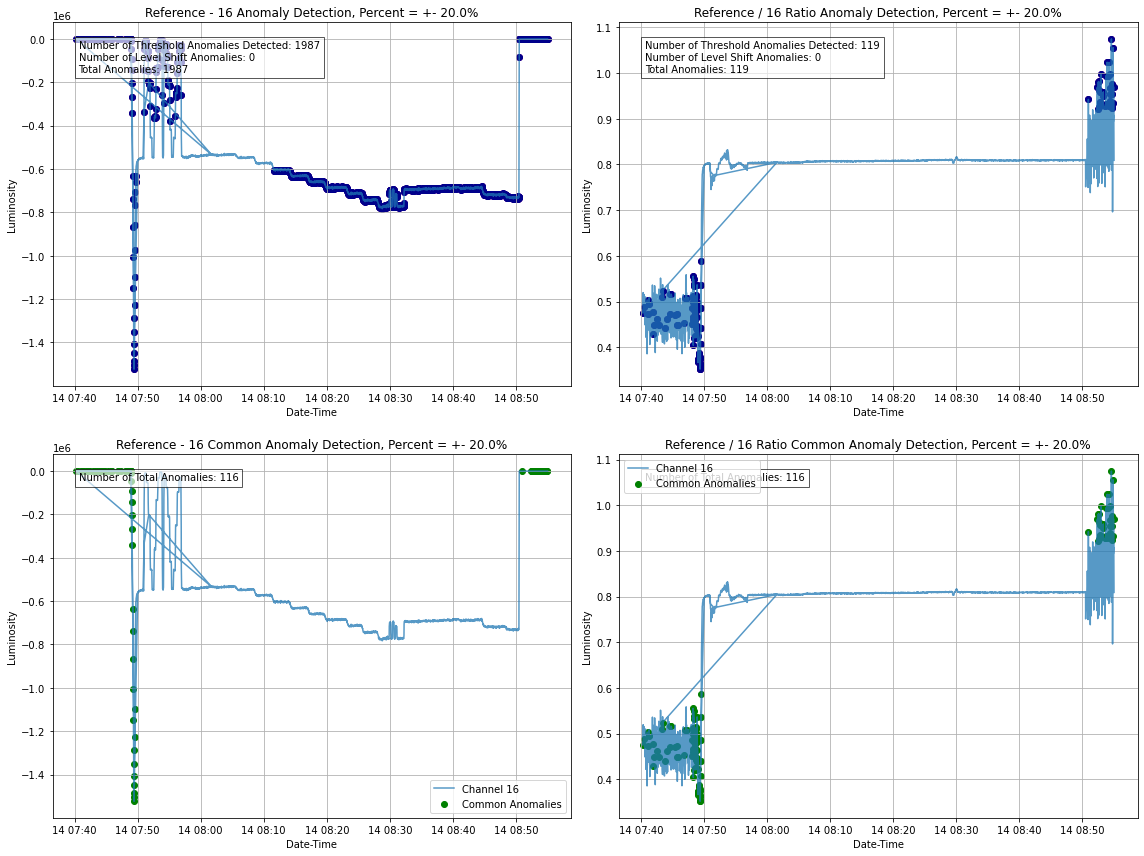

Channel 16 - Min Value: -1523118.0, Max Value: 25.0
the min and max values calculated here are -1523118.0 and 25.0
Channel 16 - Min Value: 0.35196771528773113, Max Value: 1.0748502994011977
the min and max values calculated here are 0.35196771528773113 and 1.0748502994011977
Channel 16 - Min Value: -1523118.0, Max Value: 25.0
the min and max values calculated here are -1523118.0 and 25.0
Channel 16 - Min Value: 0.35196771528773113, Max Value: 1.0748502994011977
the min and max values calculated here are 0.35196771528773113 and 1.0748502994011977


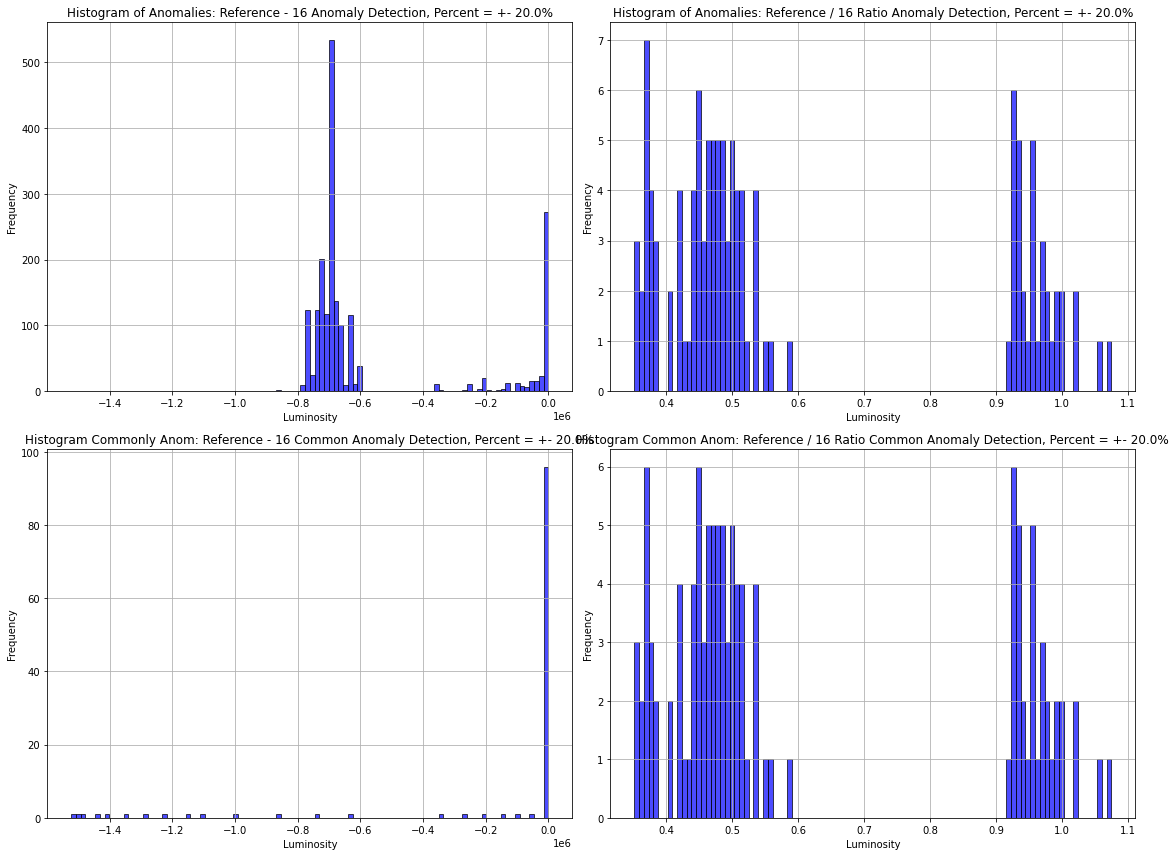

In [12]:
def full_automated(df1, threshold_high1, threshold_low1, levelshift_c_values, levelshift_windows, channel_number, df2=None, 
                   threshold_high2=None, threshold_low2=None, common_anomalies=None, title1=None, title2=None, title3=None, title4=None, show_histograms = False):
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))

    combined_anomalies1, threshold_anomaly_dates1, levelshift_anomalies_all1 = detect_anomalies(df1, threshold_high1, threshold_low1, levelshift_c_values, levelshift_windows)
    plot_anomalies(axs[0, 0], df1, combined_anomalies1, threshold_anomaly_dates1, levelshift_anomalies_all1, channel_number, title1)
    
    combined_anomalies2, threshold_anomaly_dates2, levelshift_anomalies_all2 = detect_anomalies(df2, threshold_high2, threshold_low2, levelshift_c_values, levelshift_windows)
    plot_anomalies(axs[0, 1], df2, combined_anomalies2, threshold_anomaly_dates2, levelshift_anomalies_all2, channel_number, title2)
    
    common_anomalies = combined_anomalies1.intersection(combined_anomalies2)
    num_common_anomalies = len(common_anomalies)
    print(f"Number of common anomalies in Channel {channel_number}: {num_common_anomalies}")

    plot_common_anomalies(axs[1,0], df1, common_anomalies, channel_number, title3)
    plot_common_anomalies(axs[1,1], df2, common_anomalies, channel_number, title4)
    plt.tight_layout()
    plt.show()
    
    if show_histograms:
        fig, hist_axes = plt.subplots(2, 2, figsize=(16, 12))

        anomaly_values1 = [df1.loc[idx] for idx in combined_anomalies1]
        plot_histogram(hist_axes[0, 0], anomaly_values1, channel_number, f"Histogram of Anomalies: {title1 if title1 else f'Channel {channel_number}'}")

        anomaly_values2 = [df2.loc[idx] for idx in combined_anomalies2]
        plot_histogram(hist_axes[0, 1], anomaly_values2, channel_number, f"Histogram of Anomalies: {title2 if title2 else f'Channel {channel_number}'}")

        anomaly_values3 = [df1.loc[idx] for idx in common_anomalies]
        plot_histogram(hist_axes[1, 0], anomaly_values3, channel_number, f"Histogram Commonly Anom: {title3 if title3 else f'Channel {channel_number}'}")
        
        anomaly_values4 = [df2.loc[idx] for idx in common_anomalies]
        plot_histogram(hist_axes[1, 1], anomaly_values4, channel_number, f"Histogram Common Anom: {title4 if title4 else f'Channel {channel_number}'}")
        
        plt.tight_layout()
        plt.show()

select_channel = 16  

if select_channel - 1 >= len(ch_data):
    raise IndexError(f"Channel {select_channel} is out of range for ch_data list.")

difference = reference - ch_data[select_channel - 1]['lumi']
difference.index = reference_dt
difference.index = pd.to_datetime(difference.index).floor('s')

ratio = reference / ch_data[select_channel - 1]['lumi']
ratio.index = reference_dt
ratio.index = pd.to_datetime(ratio.index).floor('s')
ratio = ratio.replace([np.inf, -np.inf], np.nan).dropna()

differencemean = np.mean(difference)
ratiomean = np.mean(ratio)

threshold_high2_ratio = ratiomean + percent * ratiomean
threshold_low2_ratio = ratiomean - percent * ratiomean

if differencemean < 0:
    threshold_high1_diff = differencemean - percent * differencemean
    threshold_low1_diff = differencemean + percent * differencemean
else:
    threshold_high1_diff = differencemean + percent * differencemean
    threshold_low1_diff = differencemean - percent * differencemean


full_automated(df1=difference, threshold_high1=threshold_high1_diff, threshold_low1=threshold_low1_diff, levelshift_c_values=levelshift, levelshift_windows=window, channel_number=select_channel,
    df2=ratio, threshold_high2=threshold_high2_ratio, threshold_low2=threshold_low2_ratio,  title1=f"Reference - {select_channel} Anomaly Detection, Percent = +- {percent * 100}%",
    title2=f"Reference / {select_channel} Ratio Anomaly Detection, Percent = +- {percent * 100}%", title3=f"Reference - {select_channel} Common Anomaly Detection, Percent = +- {percent * 100}%",
    title4=f"Reference / {select_channel} Ratio Common Anomaly Detection, Percent = +- {percent * 100}%",  show_histograms=True)

# Run this code if a channel has failed selection.

# Run this code below to append the data to csv files and to visualize BCM1F data trends for all previously inspected runs.

In [16]:
# Directory for storing channel data CSVs
csv_folder = "bcm1f_channel_data"
processed_fills = []
hist_year_data = {f"bcm1f_year_data_{ch}": [] for ch in channels}
dt_data_channel = dt_data[0]

# Create directory if it doesn't exist
if not os.path.exists(csv_folder):
    os.makedirs(csv_folder)

def process_fill(fill_number, df_ratio, titles_r):
    if fill_number in processed_fills:
        print(f"Fill number {fill_number} has already been processed.")
        return None

    for channel in channels:
        if channel in channels_failed:
            continue
        
        median_dt_index = np.round(len(dt_data_channel) / 2).astype(int)
        median_dt_time = dt_data_channel.iloc[median_dt_index]
        
        if channel not in df_ratio:
            print(f"Channel {channel} is not in df_ratio. Skipping...")
            continue
        
        valid_data = df_ratio[channel]['ratio'].replace([np.inf, -np.inf], np.nan).dropna()
        
        if not valid_data.empty:
            hist_data, bin_edges = np.histogram(valid_data, bins=100, range=(valid_data.min(), valid_data.max()))
            hist_year_data[f"bcm1f_year_data_{channel}"].append((hist_data, bin_edges))
        
    for channel in channels:
        if channel in channels_failed:
            continue
        
        # Ensure there's histogram data to process
        hist_data_list = hist_year_data.get(f"bcm1f_year_data_{channel}", [])
        if not hist_data_list:
            print(f"No histogram data for channel {channel}. Skipping...")
            continue
        
        all_hist_data = []
        
        for hist_data, bin_edges in hist_data_list:
            for bin_edge, count in zip(bin_edges, hist_data):
                all_hist_data.append({'Bin_Edges': bin_edge, 'Count': count, 'Fill_Number': fill_number, 'Date-Time': median_dt_time})
        
        new_hist_data = pd.DataFrame(all_hist_data)
        channel_filename = os.path.join(csv_folder, f"bcm1f_data_channel_{channel}.csv")
        
        if os.path.exists(channel_filename):
            existing_hist_data = pd.read_csv(channel_filename)
            if 'Fill_Number' in existing_hist_data.columns and (existing_hist_data['Fill_Number'] == fill_number).any():
                print(f"Data for fill number {fill_number} in channel {channel} has previously been processed.")
                continue
            
            combined_hist_data = pd.concat([existing_hist_data, new_hist_data])
            numeric_cols = combined_hist_data.select_dtypes(include=np.number).columns
            grouped_data = combined_hist_data.groupby('Bin_Edges', as_index=False)[numeric_cols].sum()
            
            if 'Date-Time' in combined_hist_data.columns:
                non_numeric_data = combined_hist_data[['Bin_Edges', 'Date-Time']].drop_duplicates()
                combined_hist_data = pd.merge(grouped_data, non_numeric_data, on='Bin_Edges', how='left')
            
            print(f"Fill number {fill_number} for channel {channel} has now been processed and appended to other data.")
        else:
            combined_hist_data = new_hist_data
            print(f"Created new data file for fill number {fill_number} in channel {channel}.")
        
        # Save the combined histogram data to CSV
        combined_hist_data.to_csv(channel_filename, index=False)
    
    processed_fills.append(fill_number)
    return combined_hist_data if 'combined_hist_data' in locals() else None

result = process_fill(fill_number, df_ratio, titles_r)


Data for fill number 9066 in channel 1 has previously been processed.
Data for fill number 9066 in channel 2 has previously been processed.
Data for fill number 9066 in channel 3 has previously been processed.
Data for fill number 9066 in channel 4 has previously been processed.
Data for fill number 9066 in channel 5 has previously been processed.
Data for fill number 9066 in channel 6 has previously been processed.
Data for fill number 9066 in channel 7 has previously been processed.
Data for fill number 9066 in channel 8 has previously been processed.
Data for fill number 9066 in channel 9 has previously been processed.
Data for fill number 9066 in channel 10 has previously been processed.
Data for fill number 9066 in channel 11 has previously been processed.
Data for fill number 9066 in channel 12 has previously been processed.
Data for fill number 9066 in channel 13 has previously been processed.
Data for fill number 9066 in channel 14 has previously been processed.
Data for fill n

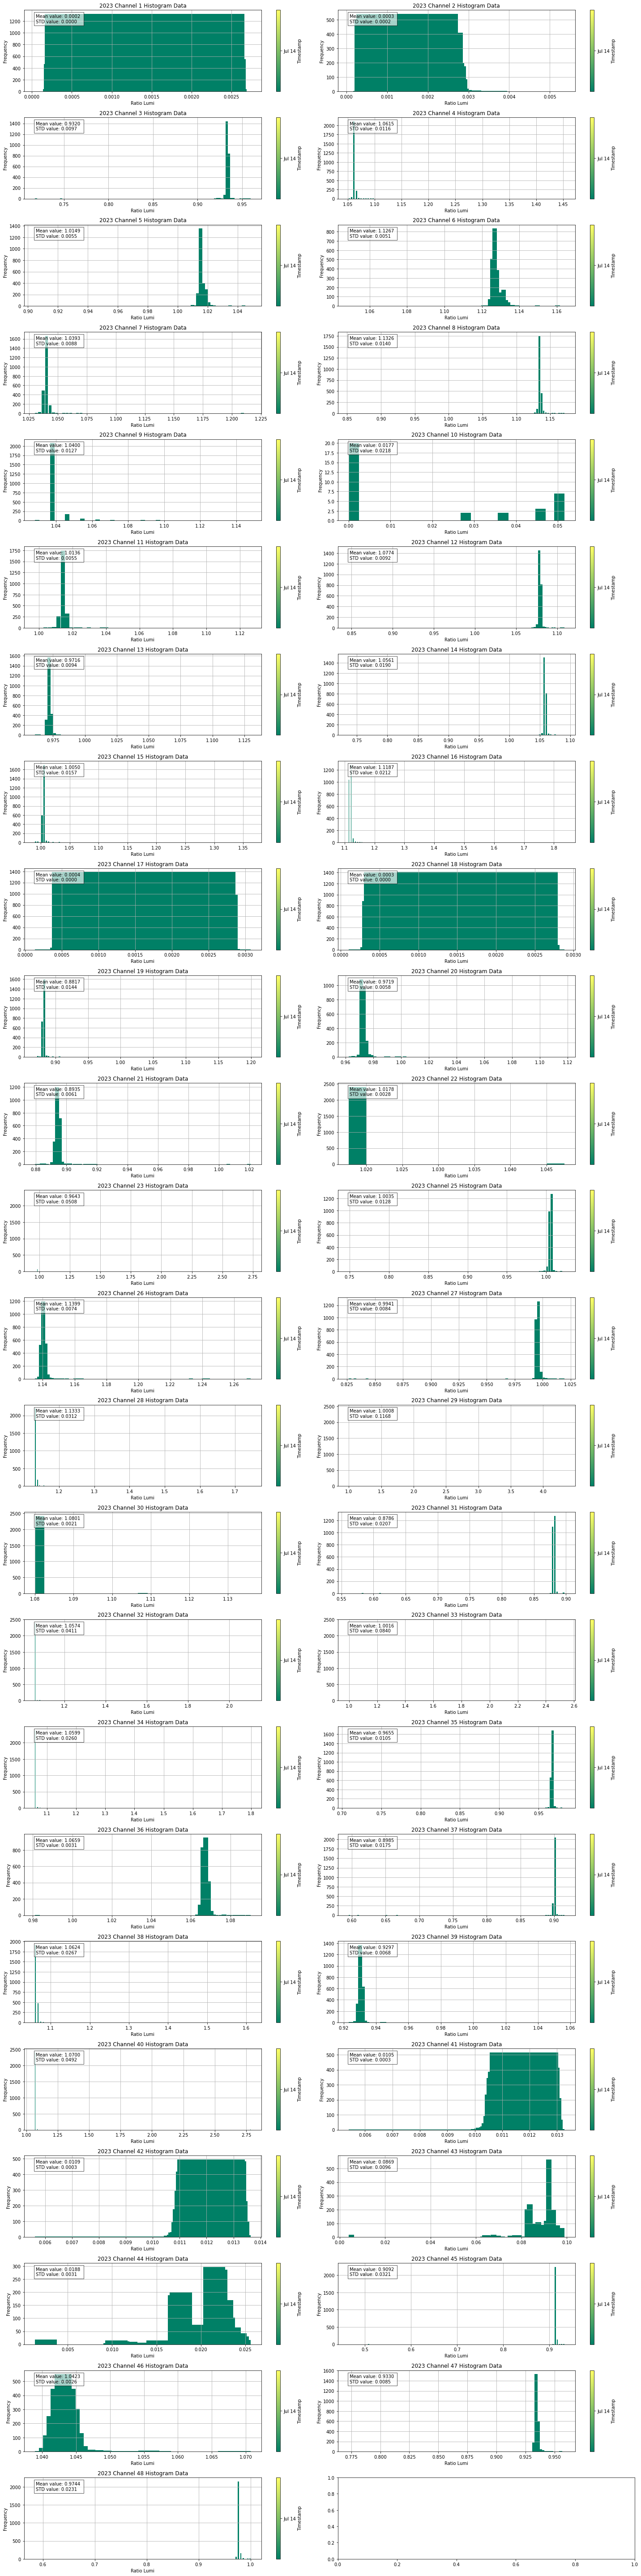

In [17]:
csv_files = [os.path.join(csv_folder, f'bcm1f_data_channel_{ch}.csv') for ch in channels_good]
csv_dfs = []
r_squared_list = []
fig, axes = plt.subplots(24, 2, figsize=(20, 80))
axes = axes.flatten()

for i, csv_file in enumerate(csv_files):
    read_csv = pd.read_csv(csv_file)
    filtered_csv = read_csv[read_csv['Count'] > 1]
    
    if not filtered_csv.empty:
        filtered_csv = filtered_csv.dropna(subset=['Date-Time'])
        bin_edges = filtered_csv['Bin_Edges']
        counts = filtered_csv['Count']
        
        weighted_sum = (bin_edges * counts).sum()
        total_counts = counts.sum()
        weighted_mean = (weighted_sum / total_counts)
        weighted_variance = (counts * (bin_edges - weighted_mean) ** 2).sum() / total_counts
        weighted_std = np.sqrt(weighted_variance)
        mu_initial = bin_edges.iloc[np.argmax(counts)]
        sigma_initial = np.std(bin_edges)
        min_value = bin_edges.min()
        max_value = bin_edges.max()
        
        df_color = pd.DataFrame({'Date-Time': filtered_csv['Date-Time']})
        df_color['Date-Time'] = pd.to_datetime(df_color['Date-Time'])
        df_color['Timestamp'] = df_color['Date-Time'].astype(np.int64) / 10**9 
        norm = plt.Normalize(df_color['Timestamp'].min(), df_color['Timestamp'].max())
        colormap = plt.cm.summer
        df_color['Color'] = df_color['Timestamp'].apply(lambda x: colormap(norm(x)))

        ax = axes[i]
        bin_width = 0.0025
        ax.bar(bin_edges, counts, width=bin_width, align='edge', color=df_color['Color'])

        cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=colormap), ax=ax)
        cbar.set_label('Timestamp')
        
        unique_dates = df_color['Date-Time'].dt.date.unique()
        unique_timestamps = [pd.Timestamp(date).timestamp() for date in unique_dates]

        cbar.set_ticks(unique_timestamps)
        cbar.set_ticklabels([pd.to_datetime(ts, unit='s').strftime('%b %d') for ts in unique_timestamps])
         
        ax.set_title(f"2023 Channel {channels_good[i]} Histogram Data")
        ax.set_xlabel("Ratio Lumi")
        ax.set_ylabel("Frequency")
        ax.grid(True)
            
        text_str = f"Mean value: {weighted_mean:.4f} \nSTD value: {weighted_std:.4f}" 
        bbox_props = dict(facecolor='white', alpha=0.65)
        ax.text(0.05, 0.95, text_str, transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=bbox_props)

    else:
        print(f"No valid data for fitting Gaussian in channel {channels_good[i]}")

    
plt.tight_layout()
plt.show()

/cvmfs/sft.cern.ch/lcg/views/LCG_105a_swan/x86_64-el9-gcc13-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Could not fit Gaussian for channel 9: Optimal parameters not found: Number of calls to function has reached maxfev = 2000.
Skipping channel 21 due to insufficient data points.
Could not fit Gaussian for channel 22: Optimal parameters not found: Number of calls to function has reached maxfev = 2000.
Could not fit Gaussian for channel 26: Optimal parameters not found: Number of calls to function has reached maxfev = 2000.
Skipping channel 27 due to insufficient data points.
Skipping channel 28 due to insufficient data points.
Could not fit Gaussian for channel 30: Optimal parameters not found: Number of calls to function has reached maxfev = 2000.
Could not fit Gaussian for channel 31: Optimal parameters not found: Number of calls to function has reached maxfev = 2000.
Could not fit Gaussian for channel 32: Optimal parameters not found: Number of calls to function has reached maxfev = 2000.
Could not fit Gaussian for channel 38: Optimal parameters not found: Number of calls to function h

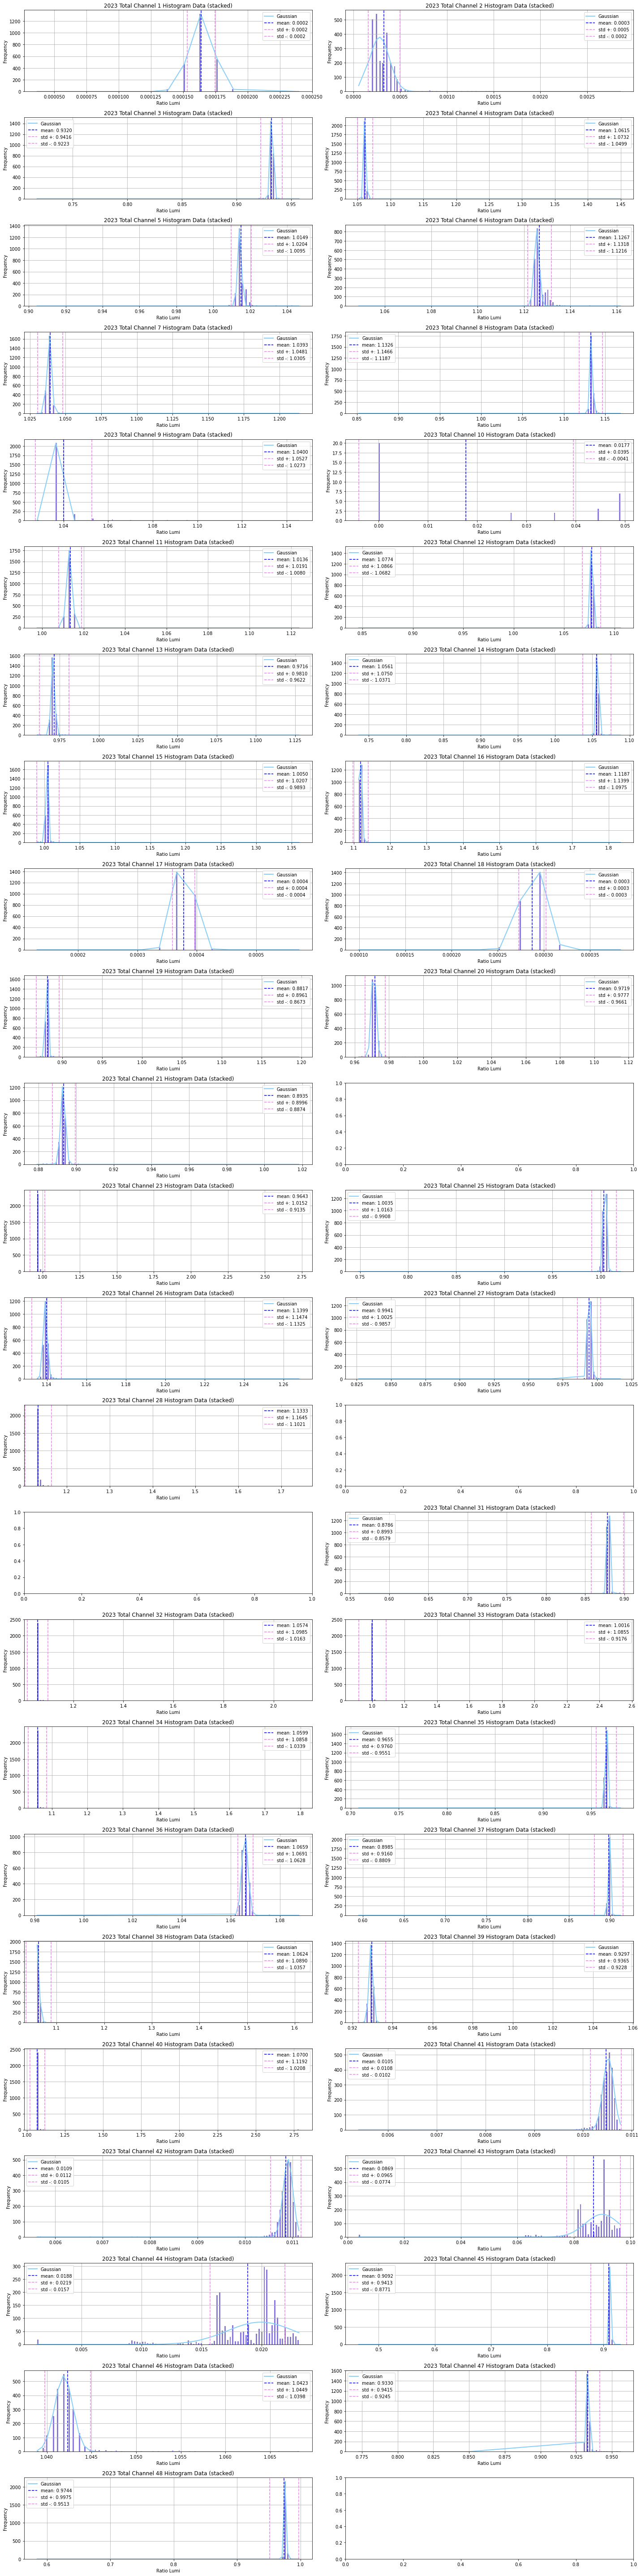

In [52]:
def gaussian(x, amp, mu, sigma):
    return amp * np.exp(-(x - mu)**2 / (2 * sigma**2))

mean_values = []
std_values = []
min_values = []
max_values = []

fig, axes = plt.subplots(24, 2, figsize=(20, 80))
axes = axes.flatten()

for i, csv_file in enumerate(csv_files):
    #reading in the csv and filtering out values not needed
    read_csv = pd.read_csv(csv_file, usecols=['Bin_Edges', 'Count', 'Date-Time'])
    filtered_csv = read_csv[read_csv['Count'] > 1]
    filtered_csv = filtered_csv.dropna(subset=['Date-Time'])
    bin_edges = filtered_csv['Bin_Edges'].values
    counts = filtered_csv['Count'].values

    #creating truncated plots to zoom in further and see distribution better
    bin_vals_large = sorted(bin_edges, reverse=True)[:0]
    bin_vals_small = sorted(bin_edges)[:0]
    bins_to_remove = set(bin_vals_large) | set(bin_vals_small)
    bin_edges = np.array([value for value in bin_edges if value not in bins_to_remove])
    counts = np.array([counts[idx] for idx, value in enumerate(bin_edges) if value not in bins_to_remove])

    # Ensure there are enough data points for fitting
    if len(bin_edges) < 4:
        print(f"Skipping channel {i} due to insufficient data points.")
        continue

    #calculating truncated mean and std values
    weighted_sum = (bin_edges * counts).sum()
    total_counts = counts.sum()
    weighted_mean = (weighted_sum / total_counts)
    mean_values.append(weighted_mean)
    weighted_variance = (counts * (bin_edges - weighted_mean) ** 2).sum() / total_counts
    weighted_std = np.sqrt(weighted_variance)
    std_values.append(weighted_std)
    
    max_value = bin_edges.max() if bin_edges.size > 0 else float('nan')
    min_value = bin_edges.min() if bin_edges.size > 0 else float('nan')
    max_values.append(max_value)
    min_values.append(min_value)
    max_counts = counts.max()
    
    #fitting a gaussian fit
    initial_guess = [max_counts, weighted_mean, weighted_std]
    fit_success = True
    
    try:
        popt, pcov = curve_fit(gaussian, bin_edges, counts, p0=initial_guess, maxfev=2000)
    except (RuntimeError, TypeError) as e:
        print(f"Could not fit Gaussian for channel {i}: {e}")
        fit_success = False

    ax = axes[i]
    ax.hist(bin_edges, bins=200, weights=counts, color='slateblue', alpha=0.8)
    if fit_success:
        ax.plot(bin_edges, gaussian(bin_edges, *popt), label='Gaussian', color='lightskyblue', linewidth=2)
    ax.axvline(x=weighted_mean, linestyle='--', color='b', label=f'mean: {weighted_mean:.4f}')
    ax.axvline(x=weighted_mean + weighted_std, linestyle='--', color='violet', label=f'std +: {(weighted_mean + weighted_std):.4f}')
    ax.axvline(x=weighted_mean - weighted_std, linestyle='--', color='violet', label=f'std -: {(weighted_mean - weighted_std):.4f}')

    ax.set_xlabel('Ratio Lumi')
    ax.set_ylabel('Frequency')
    ax.set_title(f"2023 Total Channel {channels_good[i]} Histogram Data (stacked)")
    ax.grid(True)
    ax.legend(loc='best')

plt.tight_layout()
plt.show()

# Visualize the 5 most recent fills compared to the one just loaded in.

No valid data after filtering in channel 1
No valid data after filtering in channel 2
No valid data after filtering in channel 3
No valid data after filtering in channel 4
No valid data after filtering in channel 5
No valid data after filtering in channel 6
No valid data after filtering in channel 7
No valid data after filtering in channel 8
No valid data after filtering in channel 9
No valid data after filtering in channel 10
No valid data after filtering in channel 11
No valid data after filtering in channel 12
No valid data after filtering in channel 13
No valid data after filtering in channel 14
No valid data after filtering in channel 15
No valid data after filtering in channel 16
No valid data after filtering in channel 17
No valid data after filtering in channel 18
No valid data after filtering in channel 19
No valid data after filtering in channel 20
No valid data after filtering in channel 21
No valid data after filtering in channel 22
No valid data after filtering in channel 

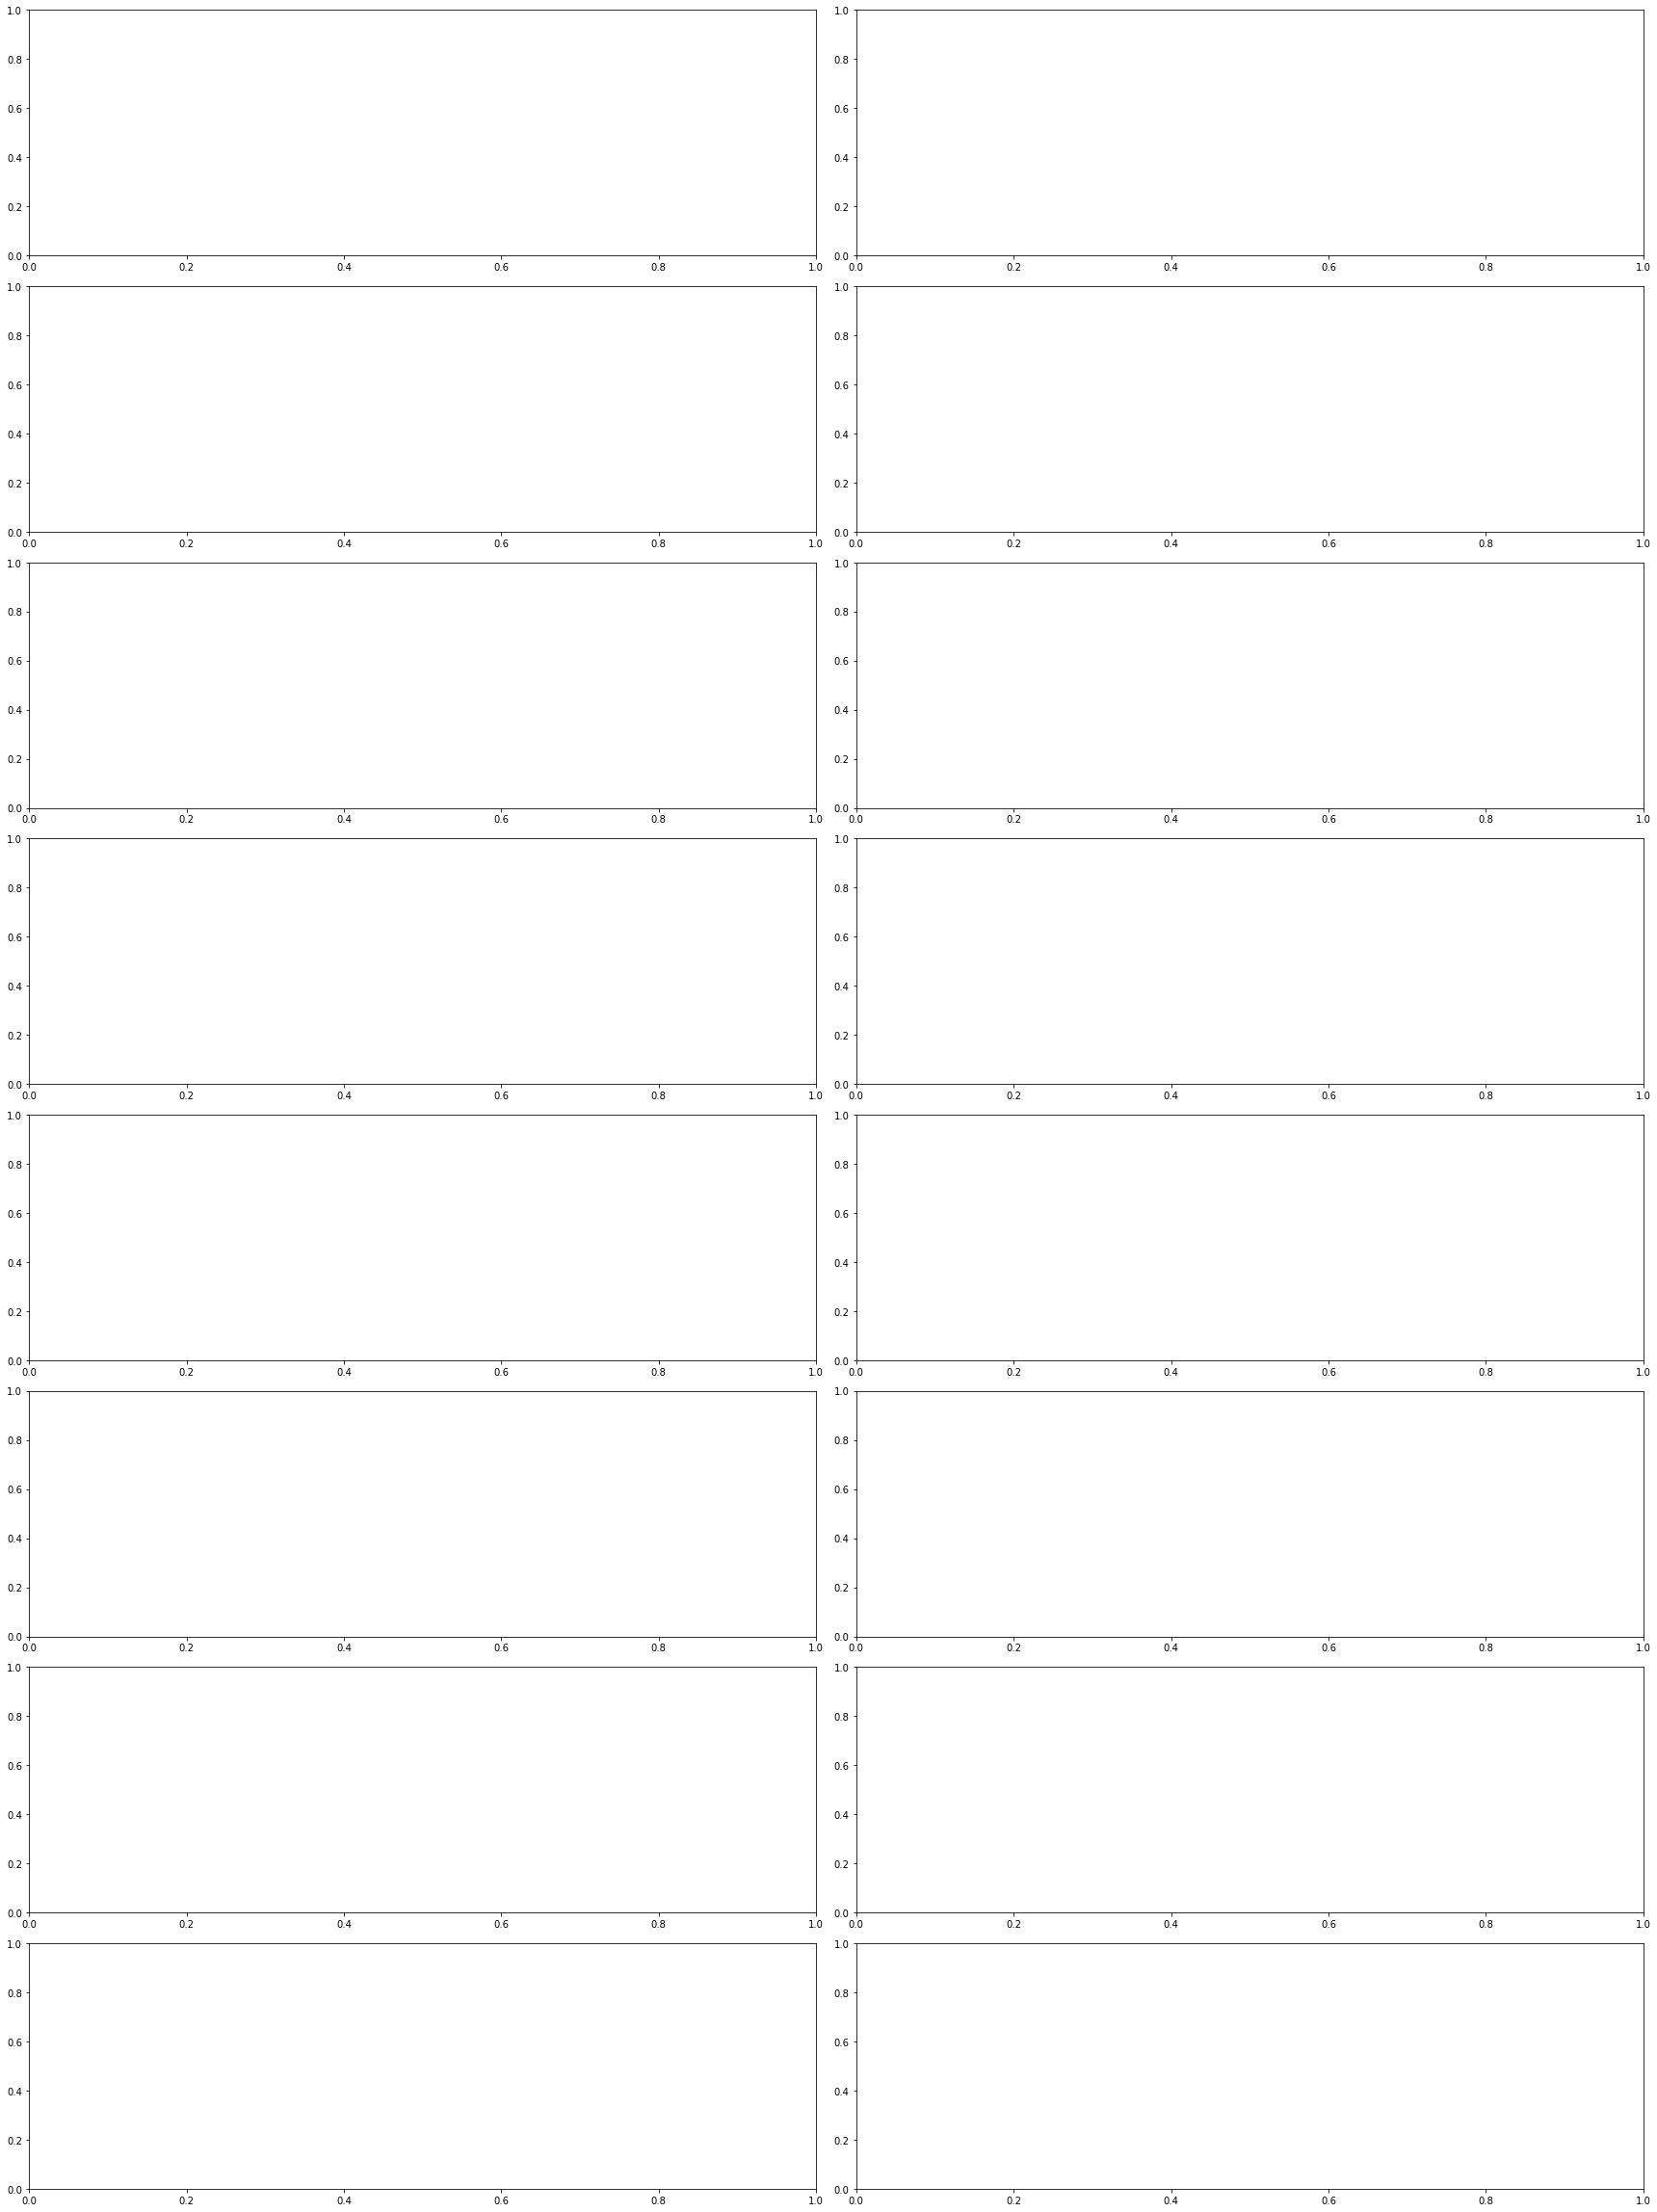

In [20]:
num_fills_desired = 5
csv_dfs = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    csv_dfs.append(df)

def find_closest_fills(dates, target_date, num_fills=num_fills_desired):
    dates = pd.to_datetime(dates, errors='coerce')
    dates = dates.dropna()
    date_diff = [(date, abs(date - target_date)) for date in dates]
    date_diff_sorted = sorted(date_diff, key=lambda x: x[1])
    closest_dates = []
    used_dates = set()
    for date, diff in date_diff_sorted:
        if len(closest_dates) >= num_fills:
            break
        if date not in used_dates:
            closest_dates.append(date)
            used_dates.add(date)
    return closest_dates

def check_date_format(df, i):
    df['Date-Time'] = pd.to_datetime(df['Date-Time'], errors='coerce')
    return df

fig, axes = plt.subplots(8, 2, figsize=(24, 32))
axes = axes.flatten()
fill_numbers_per_channel = {}
for i, (df, channel) in enumerate(zip(csv_dfs, channels_good)):

    df = check_date_format(df, i)
    filtered_df = df[df['Count'] > 1]
  
    if not filtered_df.empty:
        filtered_df = filtered_df.dropna(subset=['Date-Time'])
        current_fill_date = pd.to_datetime(reference_dt.iloc[i])
        
        all_dates = pd.concat([d['Date-Time'] for d in csv_dfs])
        all_dates = pd.to_datetime(all_dates, errors='coerce')
        
        closest_fills = find_closest_fills(all_dates, current_fill_date, num_fills=num_fills_desired + 1)
        closest_fills = [pd.Timestamp(date).tz_convert('UTC') for date in closest_fills]

        try:
            combined_df = pd.concat([
                d[d['Date-Time'].dt.floor('S').isin([fill.floor('S') for fill in closest_fills])]
                for d in [df]
            ])
        except AttributeError as e:
            print(f"Error during filtering: {e}")
            continue
        
        combined_df = combined_df.drop_duplicates()

        # Print fill numbers if available
        if 'Fill_Number' in combined_df.columns:
            fill_numbers = combined_df['Fill_Number'].unique()
            # Exclude the current fill number from the fill numbers
            fill_numbers = fill_numbers[fill_numbers != fill_number]
            
            fill_numbers_per_channel[channel] = fill_numbers
        else:
            continue

        if combined_df['Count'].sum() == 0:
            print(f"No valid data for fitting Gaussian in channel {channel}")
        else:
            bin_edges = combined_df['Bin_Edges']
            counts = combined_df['Count']

            # Filter extreme bins
            bin_edges = pd.Series(bin_edges)
            counts = pd.Series(counts)
            
            #truncating to make it easier to visualize, can remove if wanted
            bin_vals_large = sorted(bin_edges.unique(), reverse=True)[:50]
            bin_vals_small = sorted(bin_edges.unique())[:50]
            bins_to_remove = set(bin_vals_large) | set(bin_vals_small)
            
            filtered_indices = ~bin_edges.isin(bins_to_remove)
            filtered_bin_edges = bin_edges[filtered_indices]
            filtered_counts = counts[filtered_indices]
            
            filtered_bin_edges = filtered_bin_edges.to_numpy()
            filtered_counts = filtered_counts.to_numpy()

            if len(filtered_bin_edges) == 0:
                print(f"No valid data after filtering in channel {channel}")
                continue

            weighted_sum = (filtered_bin_edges * filtered_counts).sum()
            total_counts = filtered_counts.sum()
            weighted_mean = (weighted_sum / total_counts)
            weighted_variance = (filtered_counts * (filtered_bin_edges - weighted_mean) ** 2).sum() / total_counts
            weighted_std = np.sqrt(weighted_variance)

            df_color = pd.DataFrame({'Date-Time': combined_df['Date-Time']})
            df_color['Date-Time'] = pd.to_datetime(df_color['Date-Time'])
            df_color['Timestamp'] = df_color['Date-Time'].astype(np.int64) / 10**9 
            norm = plt.Normalize(df_color['Timestamp'].min(), df_color['Timestamp'].max())
            colormap = plt.cm.summer
            df_color['Color'] = df_color['Timestamp'].apply(lambda x: colormap(norm(x)))

            ax = axes[i]
            bin_width = 0.0025
            ax.bar(filtered_bin_edges, filtered_counts, width=bin_width, align='edge', color=df_color['Color'].iloc[:len(filtered_bin_edges)], alpha = 0.9)

            cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=colormap), ax=ax)
            cbar.set_label('Timestamp')
    
            unique_dates = df_color['Date-Time'].dt.date.unique()
            unique_timestamps = [pd.Timestamp(date).timestamp() for date in unique_dates]

            cbar.set_ticks(unique_timestamps)
            cbar.set_ticklabels([pd.to_datetime(ts, unit='s').strftime('%b %d') for ts in unique_timestamps])
     
            ax.set_title(f"2023 {channel} Histogram Data")
            ax.set_xlabel("Ratio Lumi")
            ax.set_ylabel("Frequency")
            ax.grid(True)
        
            text_str = f"Mean value: {weighted_mean:.4f} \nSTD value: {weighted_std:.4f}" 
            if 'fill_number' in combined_df.columns:
                fill_number = combined_df['fill_number'].unique()
                text_str += f" \nFill Number: {', '.join(map(str, fill_number))}"
            bbox_props = dict(facecolor='white', alpha=0.65)
            ax.text(0.05, 0.95, text_str, transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=bbox_props)

            
print(f"The fill numbers for the selected {num_fills_desired} fills nearest fill {fill_number} shown are: {fill_numbers}")
plt.tight_layout()
plt.show()

# Table Displaying Information Pertaining to BCM1F Channel Distributions for 2023

In [44]:
spread_values = [max_values[ch] - min_values[ch] for ch in range(len(max_values))]
mean_values_df = pd.DataFrame(mean_values, columns=['Mean'])
std_values_df = pd.DataFrame(std_values, columns=['Std'])
spread_values_df = pd.DataFrame(spread_values, columns=['Spread'])

#concatinating the mean and std and spread values together to create a df
mean_std = pd.concat([mean_values_df, std_values_df, spread_values_df], axis=1)
mean_std.index = channels_good
mean_std = mean_std.sort_index()

#finding the +- 1 sigma values
mean_std['Std Low'] = mean_std['Mean'] - mean_std['Std']
mean_std['Std High'] = mean_std['Mean'] + mean_std['Std']

outside_up = []
outside_down = []
percent_error = []
outside_sigma = []

for i, csv_file in enumerate(csv_files):
    read_csv = pd.read_csv(csv_file, usecols=['Bin_Edges', 'Count', 'Date-Time'])
    filtered_csv = read_csv[(read_csv['Count'] > 1) & read_csv['Date-Time'].notna()]

    bin_edges = filtered_csv['Bin_Edges']
    counts = filtered_csv['Count']
    mean = mean_std.iloc[i]['Mean']
    std = mean_std.iloc[i]['Std']
    
    lower_bound = mean - std
    upper_bound = mean + std
    inside_bounds = (bin_edges >= lower_bound) & (bin_edges <= upper_bound)
    outside_upper = bin_edges > upper_bound
    outside_lower = bin_edges < lower_bound

    #finding the total counts that lie above 1 sigma and below 1 sigma to then find the percentage of points that reside outside +- 1 sigma and seeing if this matches/is greater/is less than expected 32%
    counts_inside_sigma = counts[inside_bounds].sum()
    counts_outside_sigma = counts[outside_upper | outside_lower].sum()
    total_counts = counts.sum()

    outside_up.append(counts[outside_upper].sum())
    outside_down.append(counts[outside_lower].sum())

    percentage = 100 * (counts_outside_sigma / total_counts)
    percent_error.append(percentage)
    
    outside_sigma_value = 100 - percentage
    if outside_sigma_value > 68:
        outside_sigma.append('Yes')
    else:
        outside_sigma.append('No')

#adding info to table
mean_std['Points Above 1 Sigma'] = outside_up
mean_std['Points Below 1 Sigma'] = outside_down
mean_std['Percent Error'] = percent_error
mean_std['Meets 1 Sigma Expectation'] = outside_sigma
    

#visualize the table
html_std = mean_std.to_html(classes='table table-striped', index=True)

html_output = f"""
<div style="width: 80%; margin: 20px auto;">
    <h3 style="text-alicgn: center;">BCM1F Channel Histogram Data (truncated)</h3>
    {html_std}
</div>

<style>
    .table {{
        width: 100%;
        border-collapse: collapse;
        margin: 0 auto;
    }}
    .table th, .table td {{
        border: 1px solid #ddd;
        padding: 8px;
        text-align: left;
    }}
    .table th {{
        background-color: #f2f2f2;
        font-weight: bold;
    }}
    .table-striped tbody tr:nth-of-type(odd) {{
        background-color: #f9f9f9;
    }}
</style>
"""

display(HTML(html_output))

,Mean,Std,Spread,Std Low,Std High,Points Above 1 Sigma,Points Below 1 Sigma,Percent Error,Meets 1 Sigma Expectation
1,0.000164,0.000011,0.000203,0.000153,0.000175,597,515,45.667351,No
2,0.000327,0.000170,0.002801,0.000157,0.000496,104,2,4.367532,Yes
3,0.931950,0.009657,0.239699,0.922294,0.941607,27,17,1.808467,Yes
4,1.061545,0.011618,0.397949,1.049927,1.073163,39,0,1.601643,Yes
5,1.014927,0.005457,0.141726,1.009470,1.020384,67,23,3.697617,Yes
6,1.126715,0.005112,0.112948,1.121603,1.131827,106,17,5.057566,Yes
7,1.039290,0.008829,0.183662,1.030462,1.048119,42,8,2.051703,Yes
8,1.132606,0.013950,0.316242,1.118656,1.146556,27,10,1.518260,Yes
9,1.039991,0.012668,0.117385,1.027323,1.052660,176,0,7.210160,Yes
10,0.017721,0.021797,0.049094,-0.004076,0.039519,10,0,29.411765,Yes


# Visualizing all BCM1f Channel Distributions Against One Another

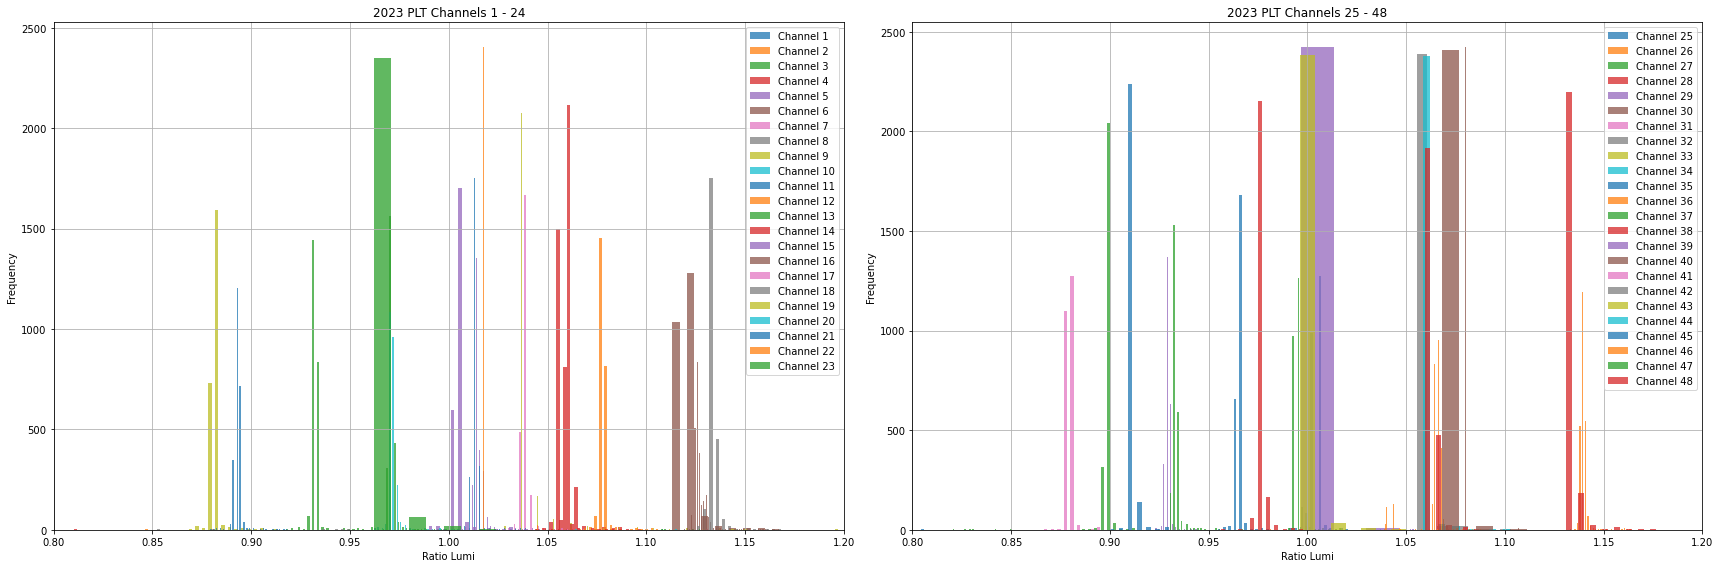

In [65]:
first_half = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
second_half = [25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]

csv_file_template = f"{csv_folder}/bcm1f_data_channel_{{}}.csv"

fig, axes = plt.subplots(1, 2, figsize=(24, 8))

# Plot for the first half
for channel in first_half:
    if channel in channels_failed:
        continue
    csv_file = csv_file_template.format(channel)
    read_csv = pd.read_csv(csv_file)
    filtered_csv = read_csv[read_csv['Count'] > 1]
    filtered_csv = filtered_csv.dropna(subset=['Date-Time'])
    bin_edges = filtered_csv['Bin_Edges']
    counts = filtered_csv['Count']
    bin_width = 0.0025
    axes[0].hist(bin_edges, bins=200, weights=counts, label=f'Channel {channel}', alpha = 0.75)  

# Plot for the second half
for channel in second_half:
    if channel in channels_failed:
        continue
    csv_file = csv_file_template.format(channel)
    read_csv = pd.read_csv(csv_file)
    filtered_csv = read_csv[read_csv['Count'] > 1]
    filtered_csv = filtered_csv.dropna(subset=['Date-Time'])
    bin_edges = filtered_csv['Bin_Edges']
    counts = filtered_csv['Count']
    bin_width = 0.0025
    axes[1].hist(bin_edges, bins=200, weights=counts, label=f'Channel {channel}', alpha = 0.75)  


axes[0].set_title("2023 PLT Channels 1 - 24")
axes[0].set_xlabel("Ratio Lumi")
axes[0].set_ylabel("Frequency")
axes[0].set_xlim(0.8,1.2)
axes[0].grid(True)
axes[0].legend(loc='best')

axes[1].set_title("2023 PLT Channels 25 - 48")
axes[1].set_xlabel("Ratio Lumi")
axes[1].set_ylabel("Frequency")
axes[1].set_xlim(0.8,1.2)
axes[1].grid(True)
axes[1].legend(loc='best')

plt.tight_layout()
plt.show()